In [1]:
import xarray as xr
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cmocean as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob2 import glob
import dask.array

from swath_rossby_wave import inversion

#### STEP0 is a version of the code set up for running a single case study for debugging 

In [2]:
# time range:  start with day0 = 0, regardless of actual start date
day0=0
day1=40

In [3]:
# set parameters
# alpha_std is the amplitude of random numbers that will be assigned to define correlated error
# mu is the mean---set to 0
#  sigma is the selected value of the correlated error.
alpha_std = np.arange(5e-4, 1.05e-2, 5e-4)
mu, sigma = 0, alpha_std[19] # std of error amp

In [4]:
# read in SWOT L2 data files.  
# note that in this code data files are used only to select lat/lon values
# swot_files = sorted(glob('./SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1/*.nc'))
swot_files = sorted(glob('./SWOT_L2_LR_SSH_Expert_474*.nc'))
swot_ds = xr.open_mfdataset(swot_files, combine='nested', concat_dim = 'num_lines') # , engine='store', chunks={'time': 10})
# swot_ds = xr.open_mfdataset(swot_files[12:22], combine='nested', concat_dim = 'num_lines') # , engine='store', chunks={'time': 10})

In [5]:
# swot_ds.to_netcdf('./swot_L2.nc')

In [6]:
# Assuming swot_ds is your dataset
# Extract the nadir position for the ground track
latitude_nadir = swot_ds['latitude_nadir'].values
longitude_nadir = swot_ds['longitude_nadir'].values-360
latitude = swot_ds['latitude'].values   
longitude = swot_ds['longitude'].values-360

In [7]:
cross_track = swot_ds['cross_track_distance'].values
depth=swot_ds['depth_or_elevation'].values
direction = np.sign(np.diff(latitude,n=1,axis=0))
time_swot = swot_ds['time'].values
time_hrs=time_swot[:].astype('datetime64[h]').astype(int)-466680

# identify ascending and descending passes
direction_asc = np.all([time_hrs >5,time_hrs < 11],axis=0)
direction_des = np.all([time_hrs >=11,time_hrs < 22],axis=0)

In [8]:
#aviso
aviso_path = './aviso_msla_ccs_1d.nc'
aviso_ds = xr.open_dataset(aviso_path)
aviso_ssh = aviso_ds.msla[:, :, 0].data
lon, lat = aviso_ds.lon.data, aviso_ds.lat.data

In [9]:
# set latitude/longitude domain
lonidx_west, lonidx_east  =  74, 110  ## new grid
latidx_south, latidx_north = 25, 65

SSHA = aviso_ds.msla[latidx_south:latidx_north, lonidx_west:lonidx_east, day0:]
SSHA=SSHA-SSHA[:, :, : ].mean(axis = -1)
T_time = aviso_ds.time.data[day0:] * 86400 # in seconds
lon, lat = (360 - aviso_ds.lon[lonidx_west:lonidx_east].data) * -1, aviso_ds.lat[latidx_south:latidx_north].data


/usr/local/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [10]:
SSHA_masked = np.ma.masked_invalid(SSHA)
ssha_mask = np.ma.getmask(SSHA_masked)

In [11]:
MSLA0 = SSHA_masked[:, :, day0:day1] #AVISO input 

In [12]:
ssha_clean = np.ma.masked_invalid(np.zeros([MSLA0.shape[0],MSLA0.shape[1],MSLA0.shape[2]]))

In [13]:
def make_error_over_time(days, alpha, latitude_use, longitude_use, deltax_use, asc_des_use):
# days, alpha, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right):
    
    '''
    This function models the time-varying error parameters in satellite swath data, including timing error, roll error, baseline dilation error, and phase error. The roll errors and baseline dilation errors are assumed to be correlated and are generated on the satellite swath. The function takes as inputs the number of days the data is repeated, the model parameters of the roll errors and baseline dilation errors, and the swath index for swath 1 and 2, as well as the swath masks.

The output of the function includes the valid data points of the timing error, roll errors, baseline dilation error, and phase error, as well as the valid coordinates as the distance from the center of the swath ("xc1_valid") and the quadratic of that distance ("xc2_valid").
    '''
    import numpy as np
    
    #print(latitude_use.shape, deltax_use.shape, latitude_use[:5],longitude_use[:5])
    
    Tdim, ALdim, ACdim = len(days), len(latitude_use), 2 # time dimension, points in swath
    timing_err = np.ma.masked_all([Tdim, ALdim])
    # Roll error
    roll_err = np.ma.masked_all([Tdim, ALdim])
    # Baseline dilation error
    baseline_dilation_err = np.ma.masked_all([Tdim, ALdim])
    # phase error
    phase_err = np.ma.masked_all([Tdim, ALdim])
    phase_err_3 = np.ma.masked_all([Tdim, ALdim])
    phase_err_4 = np.ma.masked_all([Tdim, ALdim])
    phase_err_5 = np.ma.masked_all([Tdim, ALdim])
    phase_err_6 = np.ma.masked_all([Tdim, ALdim])
    cor_err = np.ma.masked_all([Tdim, ALdim])

    for tt in range(len(days)):
        for xx in range(len(latitude_use)):
            idir=int(asc_des_use[xx])
            # timing error = alpha[0] * X^0 
            timing_err[tt,xx] = alpha[tt, 0,idir] # * xc1_left[:, xx] # alpha[0] == alpha_timing, alpha[0] * X^0  
            # roll error = alpha[1] * X^1
            roll_err[tt, xx] = alpha[tt, 1,idir] * deltax_use[xx]  # alpha[1] == alpha_roll, alpha[1] * X^1
            # baseline dialation error = alpha[2] * X^2
            baseline_dilation_err[tt, xx] = alpha[tt, 2,idir] * deltax_use[xx]**2 #  alpha[2] == alpha_baseline, alpha[2] * X^2
            # phase error
            H_neg = np.heaviside(-1 * deltax_use[xx], 1) 
            H_pos = np.heaviside(deltax_use[xx], 1)
            phase_err_3[tt, xx] = alpha[tt, 3,idir] * H_neg  
            phase_err_4[tt, xx] = alpha[tt, 4,idir] * deltax_use[xx] * H_neg
            phase_err_5[tt, xx] = alpha[tt, 5,idir] * H_pos 
            phase_err_6[tt, xx] = alpha[tt, 6,idir] * deltax_use[xx] * H_pos
            phase_err[tt, xx] = phase_err_3[tt, xx] + phase_err_4[tt, xx] + phase_err_5[tt, xx] + phase_err_6[tt,xx]
            cor_err[tt,xx] = timing_err[tt,xx] + roll_err[tt,xx] + baseline_dilation_err[tt,xx] + phase_err[tt,xx]
    
    return cor_err 



In [14]:
# generate error parameter with Gaussian distribution 
Tdim=day1-day0
alpha = np.zeros([Tdim, 7, 2]) #np.random.normal(mu, sigma, Tdim * 7).reshape(Tdim, 7) #
for nn in range(7):
    for lr in range(2):
        alpha[:, nn, lr] = np.random.normal(mu, sigma, Tdim) #TEST

In [15]:
# set up empty arrays for cross-track distance and ascending/descending mask
mask=np.zeros([latitude.shape[0],latitude.shape[1]])
deltax=np.zeros([latitude.shape[0],latitude.shape[1]])
asc_des=np.zeros([latitude.shape[0],latitude.shape[1]])

In [16]:
# fill arrays for cross-track distance, ascending/descending, and mask for data to be used.
#  note that we take every 8th point in the cross-track direction and every 16th point in the along-track direction
deltax=cross_track/1.e5 # distance in 100 km, relative to nadir
asc_des=(direction+1)/2.
for i in range(0,latitude.shape[0]-1,16):
    for j in range(2,latitude.shape[1],8):
        if(latitude[i,j]>=min(lat) and latitude[i,j]<=max(lat) and 
           depth[i,j]<=0 and longitude[i,j]<=max(lon) and longitude[i,j]>=min(lon)):
            mask[i,j]=1
        

index=np.where(mask==1)

In [17]:
# set mask for in-swath and out-of-swath grid points
mask_asc=np.zeros([len(lat),len(lon)])
mask_des=np.zeros([len(lat),len(lon)])
mask_total=np.zeros([len(lat),len(lon)])

y1=latitude[:,2]
x1=longitude[:,2]
y2=latitude[:,66]
x2=longitude[:,66]
index_asc=np.where(direction_asc[:])
lon_edge1=np.interp(lat,y1[index_asc],x1[index_asc])
lon_edge2=np.interp(lat,y2[index_asc],x2[index_asc])
index_des=np.where(direction_des[:])
lon_edge3=np.interp(lat,np.flip(y1[index_des]),np.flip(x1[index_des]))
lon_edge4=np.interp(lat,np.flip(y2[index_des]),np.flip(x2[index_des]))
for i in range(len(lat)):
    for j in range(len(lon)):
        if(lon[j]>=lon_edge1[i] and lon[j]<=lon_edge2[i]):
            mask_asc[i,j]=1
        if(lon[j]<=lon_edge3[i] and lon[j]>=lon_edge4[i]):  # descending order reversed
            mask_des[i,j]=1.  
        if(mask_asc[i,j]==1 or mask_des[i,j]==1):
            mask_total[i,j]=1 


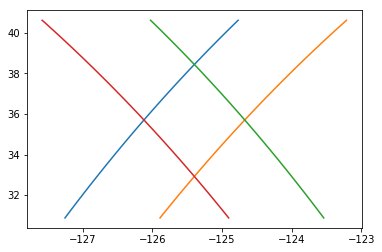

In [18]:
# plot edges of swaths
plt.plot(lon_edge1,lat)
plt.plot(lon_edge2,lat)

plt.plot(lon_edge3,lat)
plt.plot(lon_edge4,lat)

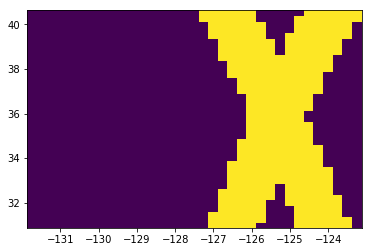

In [19]:
# verify that mask correctly separates in-swath and out-of-swath points
plt.pcolormesh(lon,lat,mask_total)

In [20]:
# define correlated error
cor_err  = make_error_over_time(range(day1-day0), alpha, latitude[index], longitude[index], deltax[index], asc_des[index])

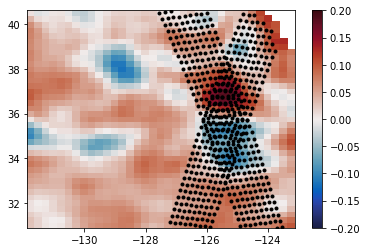

In [21]:
# plot SSH anomaly with SWOT grid points overlaid
plt.pcolor(lon, lat, SSHA[:,:,0], vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)
plt.plot(longitude[index], latitude[index], 'k.')

plt.colorbar()

In [22]:
# set parameters for Rossby wave propagation model

Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0*np.pi/180.) / Earth_radius
f0 =  2 * Omega * np.sin(Phi0*np.pi/180.) #1.0313e-4 

In [23]:
# number of modes to use---only tested for MModes = 1
MModes = 1

In [24]:
# set zonal and meridional wavenumber increments and upper/lower bounds
# nominally assume a 10 x 10 degree domain, though we actually use a slightly rectangular domain
L_lat = 10 # domain latitude length degree 
L_lon = 10 # domain longitude length

# allow for wavenumbers slightly longer than the domain size
domain_factor = 1.1 # the smaller, the less waves

k_interval = 2 * np.pi / (domain_factor * L_lon) # zonal wavemenumber interval
l_interval = 2 * np.pi / (domain_factor * L_lat) # meridional wavemenumber interval

lambda_min = 1.2 # 100km = 1 degree minimum wavelength resolved , the smaller, the more waves

k_min = 0
k_max = 2 * np.pi / lambda_min
l_max = k_max
l_min = -1 * l_max

In [25]:
# set range of k and l
k_n_orig = np.arange(k_min, k_max, k_interval) # degree^-1
l_n_orig = np.arange(l_min, l_max, l_interval) # degree^-1
k_n = k_n_orig.reshape(len(k_n_orig), MModes) #* 0 # lon, zonal propagration 
l_n = l_n_orig.reshape(len(l_n_orig), MModes) #* 0 # lon, zonal propagration                           

In [26]:
# load stratification, taken from numerical model
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

In [27]:
Psi = strat_ds.Psi.data
Rm = 5e4  / 1e5 # 50 km to degree  ## original value
wavespeed = Rm * f0  # deg / s strat_ds.C2[:MModes].data
Rm = np.array([Rm]) #unit: degree 

In [28]:
def build_h_matrix2(MSLA, MModes, k_n, l_n, longitude, latitude, T_time, Psi, Rm, day):
    
    '''
    Build H matrix or basis function for Rossby wave model.
    
    Input:
    SSHA_vector: SSH anomalies as a vector,
    Psi (horizontal velocity and pressure structure functions), 
    k_n (zonal wavenumber), 
    l_n (latitudional wavenumber), 
    frequency, 
    longitude, latitude and time. 
    
    Output: H matrix for Rossby wave model
    
    '''
    
    import numpy as np
    
    Phi0 = latitude.mean() # central latitude (φ0)
    Omega = 7.27e-5 # Ω is the angular speed of the earth
    Earth_radius = 6.371e6 / 1e5 # meters
    Beta = 2 * Omega * np.cos(Phi0*np.pi/180.) / Earth_radius 
    f0 = 2 * Omega * np.sin(Phi0*np.pi/180.) 

    dlon = longitude - longitude.mean()
    dlat = latitude - latitude.mean()
    #print('lon',lon.mean(),'lat',lat.mean())
    M = len(k_n) * len(l_n)

    omega = np.zeros([len(k_n), len(l_n), MModes])
    Iindex, Jindex, Tindex = np.zeros(MSLA.size), np.zeros(MSLA.size), np.zeros(MSLA.size)
    day_use = np.zeros(MSLA.size)
    SSHA_vector = np.zeros(MSLA.size)
    
    count = 0
    for tt in range(MSLA.shape[2]):
        for jj in range(MSLA.shape[0]):
            for ii in range(MSLA.shape[1]):
                if (MSLA[jj:jj+1,ii,tt].mask==False):
                    SSHA_vector[count] = MSLA[jj, ii, tt]
                    day_use[count]=day+tt
                    Iindex[count], Jindex[count], Tindex[count] = int(ii), int(jj), int(tt)
                    count = count + 1

    count_max=count
    H_cos, H_sin = np.zeros([count_max,M]), np.zeros([count_max, M])
    H_all = np.zeros([count_max, M * 2])
    
    # print(count_max, MModes, k_n, l_n)
    nn = 0 
    for kk in range(len(k_n)):
        for ll in range(len(l_n)):
            for mm in range(MModes):
                omega[kk, ll, mm] = Beta * k_n[kk, mm] / (k_n[kk, mm] ** 2 + l_n[ll, mm] ** 2 + Rm[mm] ** -2)          
                for count in range(count_max):
                    H_cos[count, nn] = Psi[0, mm] * np.cos(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] + omega[kk, ll, mm] * T_time[int(day_use[count])])
                    H_sin[count, nn] = Psi[0, mm] * np.sin(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] + omega[kk, ll, mm] * T_time[int(day_use[count])])
                nn += 1 
    
    H_all[:, 0::2] = H_cos 
    H_all[:, 1::2] = H_sin
    
    return H_all, SSHA_vector
    

In [29]:
def build_hswath_matrix2(MSLA, MModes, k_n, l_n, lon,lat,lon_swath, lat_swath, index, T_time, Psi, Rm, day):
    
    '''
    Build H matrix or basis function for Rossby wave model.
    
    Input:
    SSHA_vector: SSH anomalies as a vector,
    Psi (horizontal velocity and pressure structure functions), 
    k_n (zonal wavenumber), 
    l_n (latitudional wavenumber), 
    frequency, 
    longitude, latitude and time. 
    
    Output: H matrix for Rossby wave model
    
    '''
    
    import numpy as np
    
    Phi0 = lat.mean() # central latitude (φ0)
    Omega = 7.27e-5 # Ω is the angular speed of the earth
    Earth_radius = 6.371e6 / 1e5 # meters
    Beta = 2 * Omega * np.cos(Phi0*np.pi/180.) / Earth_radius 
    f0 = 2 * Omega * np.sin(Phi0*np.pi/180.) 

    dlon = lon - lon.mean()
    dlat = lat - lat.mean()
    dlon_swath = lon_swath - lon.mean()
    dlat_swath = lat_swath -lat.mean()
    #print('lon',lon.mean(),'lat',lat.mean())
    M = len(k_n) * len(l_n)

    omega = np.zeros([len(k_n), len(l_n), MModes])
#     day_use = np.zeros(MSLA.shape[2])
    
    count_max = len(index[0])
    # count = 0
    # for tt in range(MSLA.shape[2]):
    #     for jj in range(MSLA.shape[0]):
    #         for ii in range(MSLA.shape[1]):
    #             if (MSLA[jj:jj+1,ii,tt].mask==False):
    #                 SSHA_vector[count] = MSLA[jj, ii, tt]
    #                 day_use[count]=day+tt
    #                 Iindex[count], Jindex[count], Tindex[count] = int(ii), int(jj), int(tt)
    #                 count = count + 1

    # count_max=count
    ndays=MSLA.shape[2]
    H_cos, H_sin = np.zeros([ndays*count_max,M]), np.zeros([ndays*count_max, M])
    H_all = np.zeros([ndays*count_max, M * 2])
    
    # print(count_max, MModes, k_n, l_n)
    nn = 0     
    for kk in range(len(k_n)):
        for ll in range(len(l_n)):
            for mm in range(MModes):
                omega[kk, ll, mm] = Beta * k_n[kk, mm] / (k_n[kk, mm] ** 2 + l_n[ll, mm] ** 2 + Rm[mm] ** -2)          
                idata=0
                for tt in range(MSLA.shape[2]):
                    for count in range(count_max):
                        H_cos[idata, nn] = Psi[0, mm] * np.cos(k_n[kk, mm] * dlon_swath[index[0][count],index[1][count]]+ l_n[ll, mm] * dlat_swath[index[0][count],index[1][count]] + omega[kk, ll, mm] * T_time[int(day+tt)])
                        H_sin[idata, nn] = Psi[0, mm] * np.sin(k_n[kk, mm] * dlon_swath[index[0][count],index[1][count]]+ l_n[ll, mm] * dlat_swath[index[0][count],index[1][count]] + omega[kk, ll, mm] * T_time[int(day+tt)])
                        idata += 1
                nn += 1 
    
    
    H_all[:, 0::2] = H_cos 
    H_all[:, 1::2] = H_sin
    
    return H_all

In [31]:
# fill H matrix with test version from this notebook
H_all, SSHA_vector = build_h_matrix2(MSLA0, MModes, k_n, l_n, lon, lat, T_time[day0:], Psi, Rm, day0-day0)

array([-0.76904759,  0.45629703,  0.8800184 , -0.15877279, -0.8800184 ,
       -0.15877279,  0.76904759,  0.45629703,  0.55461792,  0.70145573,
        0.58084828, -0.67989444])

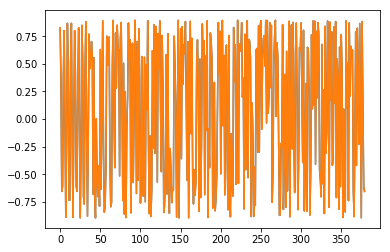

In [32]:
# plot H:  versions are the same
plt.plot(H_all[0,:])
plt.plot(H_all_orig[0,:])
H_all[0,30:42]

In [33]:
# define covariance matrix (R over P)
counter = 0
exp = -2
ssh_std = .1
k0 = k_n.max() # flat at or below k0 

M = l_n.size * k_n.size
p_diagonal = np.zeros([2 * M])
kl, kl_plot = np.zeros(M), np.zeros(2*M)
k_, l_ = np.zeros(len(k_n)*len(l_n)), np.zeros(len(k_n)*len(l_n))
counter = 0
R = 0.01 # noise = 1. cm

for kk in k_n:
    for ll in l_n:
        k_[counter] = kk 
        l_[counter]  = ll
        kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
        p_diagonal[2 * counter] = (kl[counter]+k0) ** exp 
        p_diagonal[2 * counter + 1] = (kl[counter]+k0) ** exp 
        counter += 1   

R_over_P = np.zeros([2 * M, 2 * M])
p_factor = .16/p_diagonal.sum() # variance of the model,  convert sum of variance from waven number to meter
np.fill_diagonal(R_over_P[:],  R / p_diagonal / p_factor)

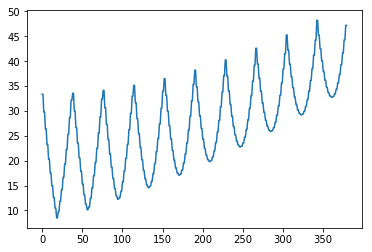

In [34]:
plt.plot(np.diagonal(R_over_P))

In [35]:
# fill H matrix using version from this notebook
#  ssha_clean fills entire grid including land points for mapping convenience in mapping
H_all_full_grid, SSHA_vector_full = build_h_matrix2(ssha_clean, MModes, k_n, l_n, lon, lat, T_time[day0:], Psi, Rm, day0-day0)

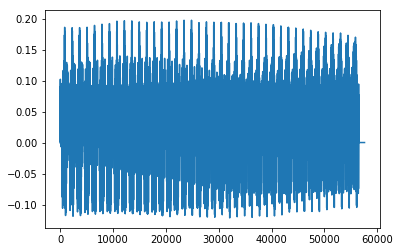

In [36]:
plt.plot(SSHA_vector)

In [37]:
amp, ssh_estimated = inversion(SSHA_vector[:H_all.shape[0]], H_all, R_over_P)

In [38]:
# multiply H * amp to reconstruct SSH
ssh_reconstructed=np.matmul(H_all_full_grid, amp)
# ssh_reconstructed=np.matmul(H_all, amp)

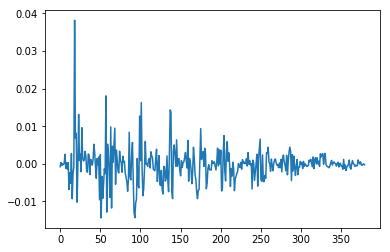

In [39]:
plt.plot(amp)

In [40]:
# define matrix for along-swath positions only
H_swath = build_hswath_matrix2(MSLA0[:,:,:], MModes, k_n, l_n, lon,lat,longitude, latitude, index, T_time, Psi, Rm, day0-day0)

In [41]:
# set indices for correlated error
IND_TIMINGl = -7 -7
IND_ROLLl = -6 -7
IND_BASELINEl = -5 -7
IND_PHASE3l, IND_PHASE4l, IND_PHASE5l, IND_PHASE6l = -4 -7, -3-7, -2-7, -1-7

IND_TIMING = -7 
IND_ROLL = -6
IND_BASELINE = -5
IND_PHASE3, IND_PHASE4, IND_PHASE5, IND_PHASE6 = -4, -3, -2, -1

In [42]:
# define correlated error
Valid_points = len(index[0]) 
err_basis_func = np.zeros([Valid_points, 2, 7])
H_swath_roll = np.zeros([Tdim*Valid_points,Tdim*14])

tt=0
for ii in range(len(index[0])):
    iuse=index[0][ii]
    juse=index[1][ii]
    iasc=int(asc_des[iuse,juse])
    #timing error
    err_basis_func[ii, iasc, IND_TIMING] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
    # roll error = alpha[1] * Xc^1
    err_basis_func[ii, iasc, IND_ROLL] = deltax[iuse,juse]  # alpha_roll, ROLL ERR, distance from nadir Xc
    # baseline dialation error = alpha[2] * Xc^2
    err_basis_func[ii, iasc, IND_BASELINE] = deltax[iuse,juse]**2  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
    # phase error 
    H_neg = np.heaviside(-1 * deltax[iuse,juse], 1) #
    H_pos = np.heaviside(deltax[iuse,juse], 1) # 
    err_basis_func[ii, iasc, IND_PHASE3] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
    err_basis_func[ii, iasc, IND_PHASE4] = deltax[iuse,juse] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
    err_basis_func[ii, iasc, IND_PHASE5] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
    err_basis_func[ii, iasc, IND_PHASE6] = deltax[iuse,juse] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)
 
err_basis_func=err_basis_func.reshape([Valid_points, 14])
    
for tt in range(Tdim):
    # print(2 * M + tt * 7 , 2 * M + (tt+1) * 7)
    H_swath_roll[tt*Valid_points:(tt+1)*Valid_points, tt * 14 : (tt+1) * 14] = err_basis_func

In [43]:
# merge H_swath (for propagating Rossby wave) and H_swath_roll (for correlated error)
H_swath_total = np.concatenate((H_swath, H_swath_roll),axis=1)

In [44]:
# determine covariance matrix for H_swath_total

p_diagonal = np.diagonal(R_over_P)
p_diagonal_roll = np.zeros([Tdim * 7*2])
p_diagonal_roll[:] = R/sigma ** 2 
R_over_P_total = np.zeros([len(p_diagonal)+len(p_diagonal_roll),len(p_diagonal)+len(p_diagonal_roll)])
# errorsR_over_P = np.zeros([2 * M, 2 * M])
#p_factor = .16/p_diagonal.sum() # variance of the model,  convert sum of variance from waven number to meter
np.fill_diagonal(R_over_P_total[:],  np.concatenate((p_diagonal,p_diagonal_roll)))

In [45]:
# multiply H_swath * amp to determine mapped SSH in swath
# amp was found using full array and is "perfect" solution
map_swath=np.matmul(H_swath,amp)

In [46]:
# create swath data with true SSH (map_swath) + correlated error
input_swath=map_swath + cor_err.reshape([len(map_swath)])

In [47]:
# invert to find one-stage best estimate of SSH and correlated error along-swath
amp_from_swath, ssh_estimated = inversion(input_swath, H_swath_total, R_over_P_total)

In [48]:
# produce gridded maps from one-stage solution
# SSH
map_swath_reconstructed=np.matmul(H_swath,amp_from_swath[:H_swath.shape[1]])
# correlated error
map_err_reconstructed=np.matmul(H_swath_roll,amp_from_swath[H_swath.shape[1]:])

In [49]:
# reshape mapped quatnites onto rectangular grid
map_swath=map_swath.reshape([MSLA0.shape[2],len(index[0])])
map_swath_reconstructed=map_swath_reconstructed.reshape([MSLA0.shape[2],len(index[0])])
map_err_reconstructed=map_err_reconstructed.reshape([MSLA0.shape[2],len(index[0])])

In [50]:
# reshape reconstructed SSH onto regular grid
ssh_reconstructed_grid=ssh_reconstructed.reshape([MSLA0.shape[2],MSLA0.shape[0],MSLA0.shape[1]])
ssh_reconstructed_grid=ssh_reconstructed_grid.transpose((1,2,0))

In [51]:
# reshape reconstructed SSH and mask land values
ssh_reconstructed_grid=ssh_reconstructed.reshape([MSLA0.shape[2],MSLA0.shape[0],MSLA0.shape[1]])
ssh_reconstructed_grid=ssh_reconstructed_grid.transpose((1,2,0))
ssh_reconstructed_grid = np.ma.masked_where(np.ma.getmask(MSLA0),ssh_reconstructed_grid)

In [52]:
# reconstruct SSH using fitted amplitude
ssh_reconstructed2=np.matmul(H_all, amp)

In [53]:
# now invert for amplitude
amp_fit, ssh_fit = inversion(ssh_reconstructed2, H_all, R_over_P)

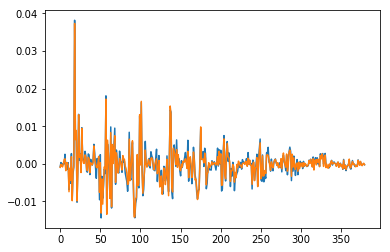

In [54]:
plt.plot(amp)
plt.plot(amp_fit)

In [55]:
# reconstruct onto full rectangular grid, using fitted amplitude
ssh_reconstructed3=np.matmul(H_all_full_grid,amp_fit)
ssh_reconstructed_grid3=ssh_reconstructed3.reshape([MSLA0.shape[2],MSLA0.shape[0],MSLA0.shape[1]])
ssh_reconstructed_grid3=ssh_reconstructed_grid3.transpose((1,2,0))
ssh_reconstructed_grid3 = np.ma.masked_where(np.ma.getmask(MSLA0),ssh_reconstructed_grid3)

In [56]:
# reconstruct onto full rectangular grid, using amplitude fitted from swath
map_swath_grid=np.matmul(H_all_full_grid,amp_from_swath[:H_swath.shape[1]])
ssh_reconstructed_from_swath=map_swath_grid.reshape([MSLA0.shape[2],MSLA0.shape[0],MSLA0.shape[1]])
ssh_reconstructed_from_swath=ssh_reconstructed_from_swath.transpose((1,2,0))
ssh_reconstructed_from_swath = np.ma.masked_where(np.ma.getmask(MSLA0),ssh_reconstructed_from_swath)

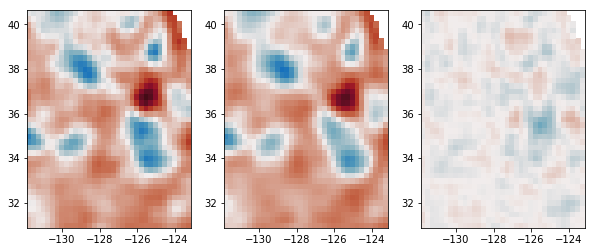

In [57]:
# plot results
# ssh_reconstructed_grid=ssh_reconstructed.reshape([MSLA0.shape[2],MSLA0.shape[0],MSLA0.shape[1]])
# ssh_reconstructed_grid=ssh_reconstructed_grid.transpose((1,2,0))
# ssh_reconstructed_grid = np.ma.masked_where(np.ma.getmask(MSLA0),ssh_reconstructed_grid)
i=10
fig, ax = plt.subplots(1,3,figsize=(10, 4))

ax[0].pcolormesh(lon, lat, SSHA[:,:,i], vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)
# plt.subplot(1,3,2)
ax[1].pcolormesh(lon,lat,ssh_reconstructed_grid[:,:,i], vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)
# plt.subplot(1,3,3)
ax[2].pcolormesh(lon,lat,SSHA[:,:,i]-ssh_reconstructed_grid[:,:,i], vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)

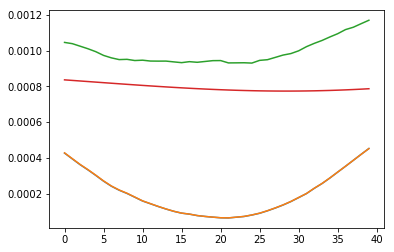

In [58]:
# compute difference on grid between truth and fitted values
grid_diff=(MSLA0[:,:,:40]-ssh_reconstructed_grid).reshape([40*36,40]) # truth vs full fit
grid_diffr=(MSLA0[:,:,:40]-ssh_reconstructed_grid3).reshape([40*36,40]) # truth vs full fit
grid_diffs=(MSLA0[:,:,:40]-ssh_reconstructed_from_swath).reshape([40*36,40]) # truth vs fit to swath
grid_diffrr=(ssh_reconstructed_grid-ssh_reconstructed_grid3).reshape([40*36,40]) # full fit vs full fit =0
grid_diffrs=(ssh_reconstructed_grid-ssh_reconstructed_from_swath).reshape([40*36,40]) # full fit vs fit on swath

# grid_diff=np.reshape(grid_diff,[40*36,40])

plt.plot(np.var(grid_diff[:,:],axis=0))
plt.plot(np.var(grid_diffr[:,:],axis=0))
plt.plot(np.var(grid_diffs[:,:],axis=0))
# plt.plot(np.var(grid_diffrr[:,:],axis=0))
plt.plot(np.var(grid_diffrs[:,:],axis=0))

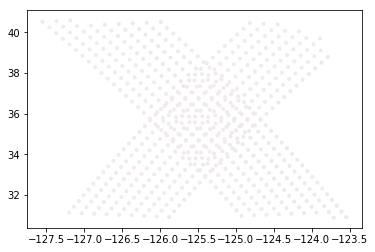

In [59]:
plt.scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',
            c=map_swath[i,:]-map_swath_reconstructed[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)

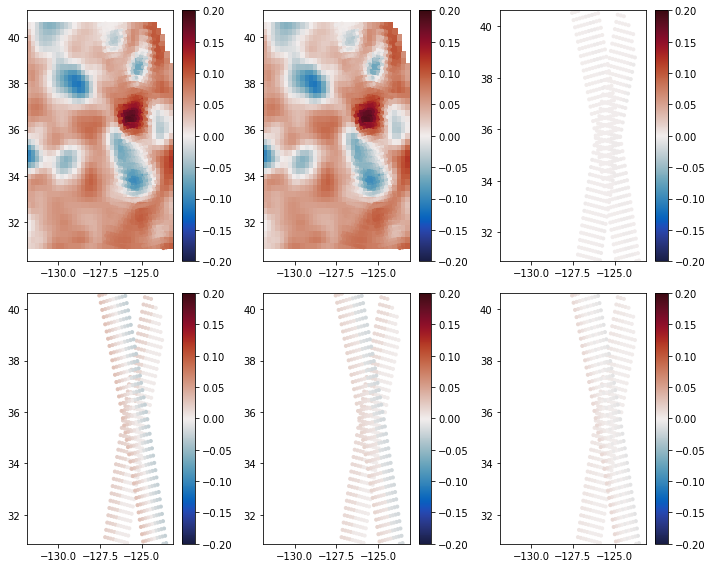

In [60]:
i=20
fig, ax = plt.subplots(2,3,figsize=(10, 8))

# plt.pcolor(lon, lat, SSHA[:,:,i], vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)
im=ax[0,0].pcolormesh(lon, lat, ssh_reconstructed_grid[:,:,i], vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)
# plt.scatter(longitude[index[0],index[1]],latitude[index[0],index[1]],map_swath,vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)
ax[0,0].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=map_swath[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
fig.colorbar(im,ax=ax[0,0])

im=ax[0,1].pcolor(lon, lat, ssh_reconstructed_grid[:,:,i], vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)
ax[0,1].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=map_swath_reconstructed[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
fig.colorbar(im,ax=ax[0,1])

ax[0,2].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',
            c=map_swath[i,:]-map_swath_reconstructed[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[0,2].axis([min(lon),max(lon),min(lat),max(lat)])
fig.colorbar(im,ax=ax[0,2])

ax[1,0].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=cor_err[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[1,0].axis([min(lon),max(lon),min(lat),max(lat)])
fig.colorbar(im,ax=ax[1,0])

# plt.subplot(2,3,5)
ax[1,1].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=map_err_reconstructed[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[1,1].axis([min(lon),max(lon),min(lat),max(lat)])
fig.colorbar(im,ax=ax[1,1])

# plt.subplot(2,3,6)
ax[1,2].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=cor_err[i,:]-map_err_reconstructed[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[1,2].axis([min(lon),max(lon),min(lat),max(lat)])
fig.colorbar(im,ax=ax[1,2])

# plt.subplot(3,3,7)
# plt.scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=cor_err[i,:]+map_swath[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
# plt.axis([min(lon),max(lon),min(lat),max(lat)])

# plt.subplot(3,3,8)
# plt.scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=map_err_reconstructed[i,:]+map_swath_reconstructed[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
# plt.axis([min(lon),max(lon),min(lat),max(lat)])

# plt.subplot(3,3,9)
# plt.scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=cor_err[i,:]+map_swath[i,:]-map_err_reconstructed[i,:]-map_swath_reconstructed[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
# plt.axis([min(lon),max(lon),min(lat),max(lat)])

#plt.scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',vmin=-0.2, vmax=0.2,c=map_swath,cmap=cmo)

plt.tight_layout()

In [61]:
# Test the function with your data
swot_longitude = longitude  # Assuming 'longitude' is defined somewhere in your environment
swot_latitude = latitude  # Assuming 'latitude' is defined somewhere in your environment
msla = aviso_ssh
day  = np.array([0])

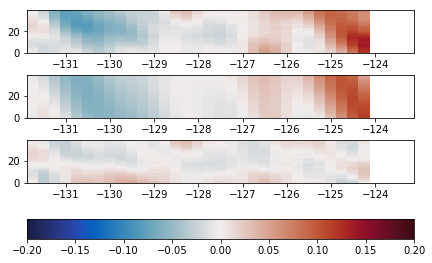

In [62]:
# Hovmoller
i=39
fig, axs = plt.subplots(3, 1)
axs[0].pcolormesh(lon,np.arange(Tdim),SSHA[i,:,day0:day0+Tdim].T, vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)

axs[1].pcolormesh(lon,np.arange(Tdim),ssh_reconstructed_grid[i,:,:].T, vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)

pos=axs[2].pcolormesh(lon,np.arange(Tdim),SSHA[i,:,day0:day0+Tdim].T-ssh_reconstructed_grid[i,:,:].T, vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)

plt.tight_layout()
fig.colorbar(pos, ax=axs, orientation='horizontal')


In [63]:
# # make a test version of the correlated error
# cor_err_test  = make_error_over_time(range(1), alpha, latitude[index], longitude[index], deltax[index], asc_des[index])

In [64]:
## plot correlated error
#plt.pcolormesh(cor_err)

In [65]:
## if necessary, save correlated error to a file
# ds_cor_err = xr.Dataset(data_vars={'cor_err' : (('count'), np.squeeze(cor_err_test)),
#                                   'asc_des' : (('count'), asc_des[index]),
#                                   'deltax' : (('count'), deltax[index]),
#                                   'longitude' : (('count'), longitude[index]),
#                                   'latitude' : (('count'), latitude[index])},
#                       attrs = dict(description=('Test case roll error for SWOT satellite at California Current one-day crossover')))
# ds_cor_err.to_netcdf('./ca_current_correlated_error_test.nc')
  